In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

/Applications/anaconda3/envs/insight/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda3/envs/insight/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


from static_grader import grader

# ML: Predicting Star Ratings


Our objective is to predict a new venue's popularity from information available when the venue opens.  We will do this by machine learning from a data set of venue popularities provided by Yelp.  The data set contains meta data about the venue (where it is located, the type of food served, etc.).  It also contains a star rating. Note that the venues are not limited to restaurants. This tutorial will walk you through one way to build a machine-learning algorithm.


## Metric


Your model will be assessed based on the root mean squared error of the number of stars you predict.  There is a reference solution (which should not be too hard to beat).  The reference solution has a score of 1. Keeping this in mind...


## A note on scoring

It **is** possible to score >1 on these questions. This indicates that you've beaten our reference model - we compare our model's score on a test set to your score on a test set. See how high you can go!



## Download and parse the incoming data


We start by downloading the data set from Amazon S3:

In [2]:
# !aws s3 sync s3://dataincubator-course/mldata/ . --exclude '*' --include 'yelp_train_academic_dataset_business.json.gz'

The training data are a series of JSON objects, in a Gzipped file. Python supports Gzipped files natively: [`gzip.open`](https://docs.python.org/2/library/gzip.html) has the same interface as `open`, but handles `.gz` files automatically.

The built-in json package has a `loads()` function that converts a JSON string into a Python dictionary.  We could call that once for each row of the file. [`ujson`](http://docs.micropython.org/en/latest/library/ujson.html) has the same interface as the built-in `json` library, but is *substantially* faster (at the cost of non-robust handling of malformed json).  We will use that inside a list comprehension to get a list of dictionaries:

### Yelp dataset documentation
https://www.yelp.com/dataset/documentation/main

Each file is composed of a single object type, one JSON-object per-line.

#### business.json
Contains business data including location data, attributes, and categories.

#### review.json
Contains full review text data including the user_id that wrote the review and the business_id the review is written for.

#### user.json
User data including the user's friend mapping and all the metadata associated with the user.

#### checkin.json
Checkins on a business.

#### tip.json
Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.

#### photo.json
Contains photo data including the caption and classification (one of "food", "drink", "menu", "inside" or "outside").

In [3]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In [4]:
# check out the data structure of data
print("Data is a %r of %r" % (type(data), type(data[0])))
print("-"*20, "\nHere is an example: \n", data[0])

Data is a <class 'list'> of <class 'dict'>
-------------------- 
Here is an example: 
 {'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 7, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}


In Scikit Learn, the labels to be predicted, in this case, the stars, are always kept in a separate data structure than the features.  Let's get in this habit now, by creating a separate list of the ratings:

In [5]:
star_ratings = [row['stars'] for row in data]

In [6]:
print("star_rating is a %r" % type(star_ratings))
print("-"*20, "\nHere are some examples: \n", star_ratings[:3])
print("-"*20, "\nThe rating is ranging from %r to %r" % (min(star_ratings), max(star_ratings))) 

star_rating is a <class 'list'>
-------------------- 
Here are some examples: 
 [3.5, 4.0, 4.0]
-------------------- 
The rating is ranging from 1.0 to 5.0


### Notes:

1. [Pandas](http://pandas.pydata.org/) is able to read JSON text directly.  Use the `read_json()` function with the `lines=True` keyword argument.  While the rest of this notebook will assume you are using a list of dictionaries, you can complete it with dataframes, if you so desire.  Some of the example code will need to be modified in this case.

2. There are obvious mistakes in the data.  There is no need to try to correct them.


## Building models


For many of the questions below, you will need to build and train an estimator that predicts the star rating given certain features.  This could be a custom estimator that you built from scratch, but in most cases will be a pipeline containing custom or pre-built transformers and an existing estimator.  We will give you hints of how to proceed, but the only requirement for you is to produce a model that does as well, or better, than the reference models we created.  You are welcome to do this however you like. The details are up to you.

The formats of the input and output to the `fit()` and `predict()` methods are ultimately up to you as well, but we recommend that you deal with lists or arrays, for consistency with the rest of Scikit Learn.  It is also a good idea to take the same type of data for the feature matrix in both `fit()` and `predict()`.  While it is tempting to read the stars from the feature matrix X, you should get in the habit of passing the labels as a separate argument to the `fit()` method.

You may find it useful to serialize the trained models to disk.  This will allow to reload it after restarting the Jupyter notebook, without needing to retrain it.  We recommend using the [`dill` library](https://pypi.python.org/pypi/dill) for this (although the [`joblib` library](http://scikit-learn.org/stable/modules/model_persistence.html) also works).  Use
```python
dill.dump(estimator, open('estimator.dill', 'w'))
```
to serialize the object `estimator` to the file `estimator.dill`.  If you have trouble with this, try setting the `recurse=True` keyword arguments in the call of `dill.dump()`.  The estimator can be deserialized by calling
```python
estimator = dill.load(open('estimator.dill', 'r'))
```

# Questions


Each of the "model" questions asks you to create a function that models the number of stars venues will receive.  It will be passed a list of dictionaries.  Each of these will have the same format as the JSON objects you've just read in.  Some of the keys (like the stars!) will have been removed.  This function should return a list of numbers of the same length, indicating the predicted star ratings.

This function is passed to the `score()` function, which will receive input from the grader, run your function with that input, report the results back to the grader, and print out the score the grader returned.  Depending on how you constructed your estimator, you may be able to pass the predict method directly to the `score()` function.  If not, you will need to write a small wrapper function to mediate the data types.


## city_avg

The venues belong to different cities.  You can imagine that the ratings in some cities are probably higher than others.  We wish to build an estimator to make a prediction based on this, but first we need to work out the average rating for each city.  For this problem, create a list of tuples (city name, star rating), one for each city in the data set.

There are many ways to do this; please feel free to experiment on your own.  If you get stuck, the steps below attempt to guide you through the process.

A simple approach is to go through all of the dictionaries in our array, calculating the sum of the star ratings and the number of venues for each city.  At the end, we can just divide the stars by the count to get the average.

We could create a separate sum and count variable for each city, but that will get tedious quickly.  A better approach to to create a dictionary for each.  The key will be the city name, and the value the running sum or running count.

One slight annoyance of this approach is that we will have to test whether a key exists in the dictionary before adding to the running tally.  The collections module's `defaultdict` class works around this by providing default values for keys that haven't been used.  Thus, if we do

In [7]:
from collections import defaultdict
star_sum = defaultdict(int)
count = defaultdict(int)

we can increment any key of `stars` or `count` without first worrying whether the key exists.  We need to go through the `data` and `star_ratings` list together, which we can do with the `zip()` function.

In [8]:
# Load and open a list of all cities in the States
usaCities = open("usaCities.js", "r").readlines()

In [9]:
for row, stars in zip(data, star_ratings):
    # increment the running sum in star_sum
    star_sum[row['city']] += stars
    # increment the running count in count
    count[row['city']] += 1

In [10]:
# show the first few items of star_sum and count
print({key:value for key, value in list(star_sum.items())[0:10]})
print({key:value for key, value in list(count.items())[0:10]})

{'Phoenix': 24646.0, 'De Forest': 22.5, 'Mc Farland': 31.0, 'Middleton': 487.5, 'Madison': 5341.0, 'Sun Prairie': 231.5, 'Windsor': 21.0, 'Monona': 191.0, 'Chandler': 5384.0, 'Scottsdale': 12325.5}
{'Phoenix': 6715, 'De Forest': 6, 'Mc Farland': 10, 'Middleton': 135, 'Madison': 1465, 'Sun Prairie': 67, 'Windsor': 6, 'Monona': 55, 'Chandler': 1468, 'Scottsdale': 3226}


Now we can calculate the average ratings.  Again, a dictionary makes a good container.

In [11]:
avg_stars = dict()
for city in star_sum:
    # calculate average star rating and store in avg_stars
    if count[city] == 0:
        avg_stars[city] = 0
    else: 
        avg_stars[city] = star_sum[city]/count[city]
        
# check the total number of cities
print("There are %d cities in total" % len(avg_stars.keys()))

There are 167 cities in total


There should be 167 different cities:

In [12]:
assert len(avg_stars) == 167

We can get that list of tuples by converting the returned view object from the `.items()` method into a list.

## city_model

Now, let's build a custom estimator that will make a prediction based solely on the city of a venue.  It is tempting to hard-code the answers from the previous section into this model, but we're going to resist and do things properly.

This custom estimator will have a `.fit()` method.  It will receive `data` as its argument `X` and `star_ratings` as `y`, and should repeat the calculation of the previous problem there.  Then the `.predict()` method can look up the average rating for the city of each record it receives.

In [14]:
from sklearn import base

class CityEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self):
        self.avg_stars = dict()
    
    def fit(self, X, y):
        """X is the data and y is the star_rating"""
        for row, stars in zip(X, y):
            star_sum[row['city']] += stars
            count[row['city']] += 1
            
        # calculate the average star rating for each city         
        avg_stars = dict()
        for city in star_sum:
            if count[city] == 0:
                avg_stars[city] = 0
            else: 
                avg_stars[city] = star_sum[city]/count[city]
    
        # Store the average rating per city in self.avg_stars
        self.avg_stars = avg_stars
        return self
    
    def predict(self, X, y=None):
        return [self.avg_stars[row['city']] for row in X if row['city'] in self.avg_stars]

/Applications/anaconda3/envs/insight/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Now we can create an instance of our estimator and train it.

In [15]:
city_est = CityEstimator()
city_est.fit(data, star_ratings)

CityEstimator()

And let's see if it works.

In [16]:
city_est.predict(data[:5])

[3.6702903946388683, 3.75, 3.75, 3.75, 3.75]

There is a problem, however.  What happens if we're asked to estimate the rating of a venue in a city that's not in our training set?

In [17]:
city_est.predict([{'city': 'Timbuktu'}])

[]

Solve this problem before submitting to the grader.

## lat_long_model

You can imagine that a city-based model might not be sufficiently fine-grained. For example, we know that some neighborhoods are trendier than others.  Use the latitude and longitude of a venue as features that help you understand neighborhood dynamics.

Instead of writing a custom estimator, we'll use one of the built-in estimators in Scikit Learn.  Since these estimators won't know what to do with a list of dictionaries, we'll build a `ColumnSelectTransformer` that will return an array containing selected keys of our feature matrix.  While it is tempting to hard-code the latitude and longitude in here, this transformer will be more useful in the future if we write it to work on an arbitrary list of columns.

In [319]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        return [[row[col_name] for col_name in self.col_names] for row in X]

Let's test it on a single row, just as a sanity check:

In [19]:
cst = ColumnSelectTransformer(['latitude', 'longitude'])
assert (cst.fit_transform(data[:1])
        == [[data[0]['latitude'], data[0]['longitude']]])

Now, let's feed the output of the transformer in to a `sklearn.neighbors.KNeighborsRegressor`.  As a sanity check, we'll test it with the first 5 rows.  To truly judge the performance, we'd need to make a test/train split.

In [20]:
from sklearn.neighbors import KNeighborsRegressor

data_transform = cst.fit_transform(data)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)
test_data = data[:5]
test_data_transform = cst.transform(test_data)
knn.predict(test_data_transform)

/Applications/anaconda3/envs/insight/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


array([4. , 4.2, 4. , 3.8, 4.2])

Instead of doing this by hand, let's make a pipeline.  Remember that a pipeline is made with a list of (name, transformer-or-estimator) tuples. 

In [21]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('cst', ColumnSelectTransformer(['latitude', 'longitude'])),
                       ('knn', KNeighborsRegressor(n_neighbors=5))])

# This should work the same way.
pipe.fit(data, star_ratings)
pipe.predict(test_data)

array([4. , 4.2, 4. , 3.8, 4.2])

The `KNeighborsRegressor` takes the `n_neighbors` hyperparameter, which tells it how many nearest neighbors to average together when making a prediction.  There is no reason to believe that 5 is the optimum value.  Determine a better value of this hyperparameter.   There are several ways to do this:

1. Use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) to split your data in to a training set and a test set.  Score the performance on the test set.  After finding the best hyperparameter, retrain the model on the full data at that hyperparameter value.

2. Use [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) to return cross-validation scores on your data for various values of the hyperparameter.  Choose the best one, and retrain the model on the full data.

3. Use [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) to do the splitting, training, and grading automatically.  `GridSearchCV` takes an estimator and acts as an estimator.  You can either give it the `KNeighborsRegressor` directly and put it in a pipeline, or you can pass the whole pipeline into the `GridSearchCV`.  In the latter case, remember that the hyperparameter `param` of an estimator named `est` in a pipeline becomes a hyperparameter of the pipeline with name `est__param`.

No matter which you choose, you should consider whether the data need to be shuffled.  The default k-folds split doesn't shuffle.  This is fine, if the data are already random.  The code below will plot a rolling mean of the star ratings.  Do you need to shuffle the data?

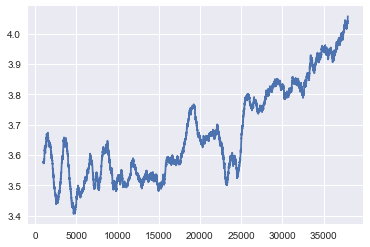

In [22]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean())

Once you've found a good value of `n_neighbors`, submit the model to the grader.  (*N.B.* "Good" is a relative measure here.  The reference solution has a r-squared value of only 0.02.  There is just rather little signal available for modeling.)

#### Hyper-tuning using train_test_split

In [40]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# train on a KneighborsRegressor
def hypertuning_knn(X, y, list_n_neighbors):
    scores_param = {}
    for n in list_n_neighbors:
        pipe = Pipeline([('cst', ColumnSelectTransformer(['latitude', 'longitude'])),
                           ('knn', KNeighborsRegressor(n_neighbors=n))])

        # split the data into training and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        pipe.fit(X_train, y_train)
        scores_param[n] = pipe.score(X_test, y_test)
    return scores_param
    

scores_param = hypertuning_knn(data, star_ratings, list_n_neighbors=[1,3,5,7,9,11,15,21,51])
print(scores_param)

In [137]:
est.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__cst', 'estimator__knn', 'estimator__cst__col_names', 'estimator__knn__algorithm', 'estimator__knn__leaf_size', 'estimator__knn__metric', 'estimator__knn__metric_params', 'estimator__knn__n_jobs', 'estimator__knn__n_neighbors', 'estimator__knn__p', 'estimator__knn__weights', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [190]:
from sklearn.model_selection import GridSearchCV

cst = ColumnSelectTransformer(['latitude', 'longitude'])
X = cst.fit_transform(data)

knn = KNeighborsRegressor()
gs = GridSearchCV(knn, {'n_neighbors':range(65,200)}, cv=5, n_jobs=2, scoring='neg_mean_squared_error')
gs.fit(X, star_ratings)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_neighbors': range(65, 200)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [181]:
sorted(gs.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [188]:
print(gs.best_estimator_.score(X,star_ratings))

0.029956689491898558


In [189]:
print (gs.best_params_)

{'n_neighbors': 200}


In [156]:
knn = KNeighborsRegressor()
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [153]:
!ls ../week2/
#http://localhost:8888/notebooks/Documents/JL/DS/Mini%20challenges/week2/ml-Tandhui.ipynb

json_to_csv_converter.ipynb
ml-Tandhui.ipynb
tutorial
usaCities.js
yelp_dataset
yelp_train_academic_dataset_business.json.gz


In [48]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

# train on a RandomForestRegressor
def hypertuning_rfr(X, y, n_estimators):
    scores_param = {}
    for n in n_estimators:
        pipe = Pipeline([('cst', ColumnSelectTransformer(['latitude', 'longitude'])),
                           ('rfr', RandomForestRegressor(n))])

        # split the data into training and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        pipe.fit(X_train, y_train)
        scores_param[n] = pipe.score(X_test, y_test)
    return scores_param
    

In [50]:
scores_param = hypertuning_rfr(data, star_ratings, n_estimators=[20,300])
print(scores_param)

{20: -0.14603679288276794, 300: -0.12000135685754378}


In [75]:
### Hyper-tuning cross_val_score
from sklearn.model_selection import cross_val_score
import pandas as pd

# train on a KneighborsRegressor
def hypertuning_knn_cv(X, y, list_cv, list_n_neighbors):
    #scores_param = pd.DataFrame(columns=['cv', 'n_neighbors','score'])
    scores_param = []
    for n in list_cv:
        for m in list_n_neighbors:
            pipe = Pipeline([('cst', ColumnSelectTransformer(['latitude', 'longitude'])),
                               ('knn', KNeighborsRegressor(n_neighbors=m))])
            pipe.fit(X, y)
            score = cross_val_score(pipe, X, y, cv=n)
            scores_param.append(score)
    return scores_param   

In [78]:
scores_param = hypertuning_knn_cv(data, star_ratings, list_cv = [3,5], list_n_neighbors=[3,5,7,15])
print(scores_param)

[array([-0.32502436, -0.28553584, -0.28963989]), array([-0.20758574, -0.1670027 , -0.2089565 ]), array([-0.15297115, -0.11288909, -0.175678  ]), array([-0.07527498, -0.0442098 , -0.12591102]), array([-0.31549519, -0.30471373, -0.27840234, -0.23983105, -0.29162815]), array([-0.19255274, -0.19782576, -0.1575624 , -0.13399581, -0.20373689]), array([-0.1377884 , -0.14888204, -0.09078335, -0.07671958, -0.16890374]), array([-0.06782384, -0.07542515, -0.02708822, -0.02224376, -0.12300384])]


*Item for thought:* Why do we choose a non-linear model for this estimator?

*Extension:* Use a `sklearn.ensemble.RandomForestRegressor`, which is a more powerful non-linear model.  Can you get better performance with this than with the `KNeighborsRegressor`?

## category_model

While location is important, we could also try seeing how predictive the
venue's category is.  Build an estimator that considers only the categories.

The categories come as a list of strings, but the built-in estimators all need numeric input.  The standard way to deal with categorical features is **one-hot encoding**, also known as dummy variables.  In this approach, each category gets its own column in the feature matrix.  If the row has a given category, that column gets filled with a 1.  Otherwise, it is 0.

The `ColumnSelectTransformer` from the previous question can be used to extract the categories column as a list of strings.  Scikit Learn provides [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer), which takes in a list of dictionaries.  It creates a column in the output matrix for each key in the dictionary and fills it with the value associated with it.  Missing keys are filled with zeros.  Therefore, we need only build a transformer that takes a list of strings to a dictionary with keys given by those strings and values of one.

In [97]:
print(data[0])
cat = ColumnSelectTransformer(['categories'])
categories_lis = cat.fit_transform(data)

print("-"*25, "\nThis is a few examples of extracted data:", categories_lis[:3])
print("-"*25, "\nThere are a total of %d category entries" % len(categories_lis))

{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 7, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}
------------------------- 
This is a few examples of extracted data: [[['Doctors', 'Health & Medical']], [['Restaurants']], [['American (Traditional)', 'Restaurants']]]
------------------------- 
There are a total of 37938 category entries


In [120]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will come in as a list of lists of lists.  Return a list of
        # dictionaries corresponding to those inner lists.
        cat_encoded =  [{i:1 for i in row[0]} for row in X]
        return cat_encoded

That should allow this to pass:

In [121]:
assert (DictEncoder().fit_transform([[['a']], [['b', 'c']]])
        == [{'a': 1}, {'b': 1, 'c': 1}])

In [126]:
encoder = DictEncoder()
categories_encoded = encoder.fit_transform(categories_lis)

print("Here are the first three examples of encoded category data:\n", categories_encoded[:2])

Here are the first three examples of encoded category data:
 [{'Doctors': 1, 'Health & Medical': 1}, {'Restaurants': 1}]


Set up a pipeline with your `ColumnSelectTransformer`, your `DictEncoder`, the `DictVectorizer`, and a regularized linear model, like `Ridge`, as the estimator.  This model will have a large number of features, one for each category, so there is a significant danger of overfitting.  Use cross validation to choose the best regularization parameter.

In [195]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import Ridge

dict_vect = DictVectorizer()
tfidf = TfidfTransformer()
rdg = Ridge()


def hypertuning_reg(X, y, list_cv, list_reg):
    scores_param = []
    for n in list_cv:
        for alpha in list_reg:
            pipe = Pipeline([('cat', ColumnSelectTransformer(['categories'])),
                             ('encoder', DictEncoder()),
                             ('dict_vect', DictVectorizer()),
                               ('rdg', Ridge(alpha = alpha))])
            pipe.fit(X, y)
            score = cross_val_score(pipe, X, y, cv=n)
            scores_param.append(score)
    return scores_param


def hypertuning_reg_with_tfidf(X, y, list_cv, list_reg):
    scores_param = []
    for n in list_cv:
        for alpha in list_reg:
            pipe = Pipeline([('cat', ColumnSelectTransformer(['categories'])),
                             ('encoder', DictEncoder()),
                             ('dict_vect', DictVectorizer()),
                             ('tfidf', TfidfTransformer()),
                               ('rdg', Ridge(alpha = alpha))])
            pipe.fit(X, y)
            score = cross_val_score(pipe, X, y, cv=n)
            scores_param.append(score)
    return scores_param

In [280]:
scores_param = hypertuning_reg(data, star_ratings, list_cv = [3,5], list_reg=[1000.0, 2000.0, 5000.0])
print("hypertuning:\n")

hypertuning:



In [290]:
for row in scores_param:
    print("average score is: ", np.mean(row, dtype=np.float64))

average score is:  0.026456742754427626
average score is:  0.008036054904365134
average score is:  -0.012736332624834278
average score is:  0.050442339870729144
average score is:  0.03134396754545221
average score is:  0.009390218728935973


In [291]:
scores_param = hypertuning_reg_with_tfidf(data, star_ratings, list_cv = [3,5], list_reg=[1000.0, 2000.0, 5000.0])
print("hypertuning:\n")
for row in scores_param:
    print("average score is: ", np.mean(row, dtype=np.float64))

hypertuning:

average score is:  0.0025386791065200587
average score is:  -0.016814396614609706
average score is:  -0.035863711614534055
average score is:  0.026045175376597562
average score is:  0.005423783916888469
average score is:  -0.015687250889696448


In [ ]:
grader.score('ml__category_model', category_est.predict)  # Edit to appropriate name

*Extension:* Some categories (e.g. Restaurants) are not very specific.  Others (Japanese sushi) are much more so.  One way to deal with this is with an measure call term-frequency-inverse-document-frequency (TF-IDF).  Add in a `sklearn.feature_extraction.text.TfidfTransformer` between the `DictVectorizer` and the linear model, and see if that improves performance.

*Extension:* Can you beat the performance of the linear estimator with a
non-linear model?

## attribute_model

There is even more information in the attributes for each venue.  Let's build an estimator based on these.

Venues attributes may be nested:
```
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
We wish to encode them with one-hot encoding.  The `DictVectorizer` can do this, but only once we've flattened the dictionary to a single level, like so:
```
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```

Build a custom transformer that flattens the attributes dictionary.  Place this in a pipeline with a `DictVectorizer` and a regressor.

You may find it difficult to find a single regressor that does well enough.  A common solution is to use a linear model to fit the linear part of some data, and use a non-linear model to fit the residual that the linear model can't fit.  Build a residual estimator that takes as an argument two other estimators.  It should use the first to fit the raw data and the second to fit the residuals of the first.

In [318]:
class FlattenTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self):
        return None  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        attri_flat = []
        for row in X:
            attri_dict = {}
            for key, values in row[0].items():
                if isinstance(values, dict):
                    for values_key, values_value in values.items():
                        attri_dict[key + '_' + values_key] = values_value
                else:
                    attri_dict[key] = values
            attri_flat.append(attri_dict)
        return attri_flat

In [243]:
pipe = Pipeline([('attri_cst', ColumnSelectTransformer(['attributes'])),
                             ('ft', FlattenTransformer()),
                             ('dict_vect', DictVectorizer()),
                               ('rdg', Ridge(alpha = 1.0))
                ])
pipe.fit(data, star_ratings)
score = cross_val_score(pipe, data, star_ratings, cv=5)


print("Average score is: ", sum(score)/len(score))

In [262]:
### Linear and non-linear modeling 
pipe = Pipeline([('attri_cst', ColumnSelectTransformer(['attributes'])),
                 ('ft', flattenTransformer()),
                 ('dict_vect', DictVectorizer()),
                 ('rdg', Ridge(alpha = 1.0))
                 ])
pipe.fit(data, star_ratings)
accuracy = cross_val_score(pipe, data, star_ratings, scoring='accuracy', cv=5)
print("Average score is: ", sum(score)/len(score))

Average score is:  0.028847728567177055


In [269]:
import numpy as np 
y_pred = pipe.predict(data)
print(y_pred[:10])
y_error = star_ratings - y_pred
# y_error = abs(diff.astype(float))
print(y_error[:10])
print(type(y_error))

[4.05441945 3.48145664 3.73445836 3.24176479 3.19597243 3.70723667
 3.70723667 3.67546963 3.70723667 3.25353111]
[0.55441945 0.51854336 0.26554164 1.25823521 0.80402757 2.20723667
 1.70723667 1.17546963 0.79276333 0.24646889]
<class 'numpy.ndarray'>


In [326]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [357]:
class ModelTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, linearmodel, nonlinearmodel):
        self.linearmodel = linearmodel
        self.nonlinearmodel = nonlinearmodel
        return None
    
    def fit(self, X, y):
        # When fit() is called, the estimator should be fit. 
        self.linearmodel.fit(X,y)
        y_res = y - self.linearmodel.predict(X)
        self.nonlinearmodel.fit(X,y_res)
        self.y_res = y_res
#         print(y_res.shape())
        #assert self.y_res.shape() == y.shape()
        return self 
    
    def score(self, X, y):
        score = (self.linearmodel.score(X, y) + self.nonlinearmodel.score(X,self.y_res))/2
        return score
    
    def predict(self, X):
        y_pred = self.linearmodel.predict(X) + self.nonlinearmodel.predict(X)
        return y_pred
    

In [358]:
pipe2 = Pipeline([('attri_cst', ColumnSelectTransformer(['attributes'])),
                  ('ft', flattenTransformer()),
                  ('dict_vect', DictVectorizer()),
                  ('mt', ModelTransformer(Ridge(), RandomForestRegressor()))
                  ])

pipe2.fit(data, star_ratings)

TypeError: 'tuple' object is not callable

In [ ]:
pipe2.score(data, star_ratings)

In [ ]:
score = cross_val_score(pipe2, data, star_ratings, cv=5)


print("Average score is: ", score.mean())

## full model 
So far we have only built models based on individual features.  Now we will build an ensemble regressor that averages together the estimates of the four previous regressors.

In order to use the existing models as input to an estimator, we will have to turn them into transformers.  (A pipeline can contain at most a single estimator.)  Build a custom `ModelTransformer` class that takes an estimator as an argument.  When `fit()` is called, the estimator should be fit.  When `transform()` is called, the estimator's `predict()` method should be called, and its results returned.

Note that the output of the `transform()` method should be a 2-D array with a single column, in order for it to work well with the Scikit Learn pipeline.  If you're using NumPy arrays, you can use `.reshape(-1, 1)` to create a column vector.  If you are just using Python lists, you will want a list of lists of single elements.

In [ ]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        # What needs to be done here?
    
    def fit(self, X, y):
        # Fit the stored estimator.
        # Question: what should be returned?
    
    def transform(self, X):
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.

This should work as follows:

In [ ]:
city_trans = EstimatorTransformer(city_est)
city_trans.fit(data, star_ratings)
assert ([r[0] for r in city_trans.transform(data[:5])]
        == city_est.predict(data[:5]))

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [ ]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
        # FeatureUnions use the same syntax as Pipelines
    ])

This should return a feature matrix with four columns.

In [ ]:
union.fit(data, star_ratings)
trans_data = union.transform(data[:10])
assert trans_data.shape == (10, 4)

Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [ ]:
grader.score('ml__full_model', full_est.predict)  # Edit to appropriate name

*Extension:* By combining our models with a linear model, we will be unable to notice any correlation between features.  We don't expect all attributes to have the same effect on all venues.  For example, "Ambiance: divey" might be a bad indicator for a restaurant but a good one for a bar.  Nonlinear models can pick up on this interaction.  Replace the linear model combining the predictions with a nonlinear one like [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor).  Better yet, use the nonlinear model to fit the residuals of the linear model.

The score for this question is just a ratio of the score of your model to the score of a reference solution.  Can you beat the reference solution and get a score greater than 1.0?

*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*